**Import libraries**

In [44]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [45]:
BATCH_SIZE = 3
IMAGE_SIZE = 256
EPOCHS = 10
CHANNELS = 3

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 30 files belonging to 3 classes.


In [47]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [48]:
len(dataset)

10

In [49]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


**Visualize the dataset**

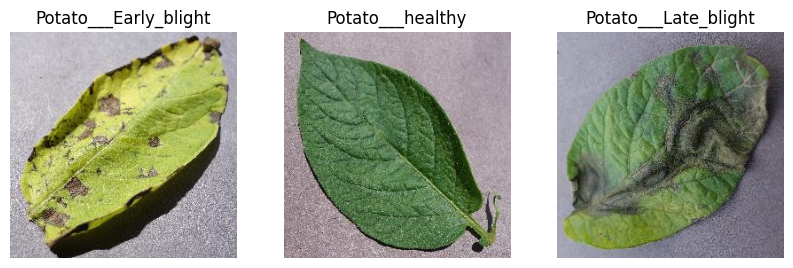

In [50]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10%validation, 10% 

In [51]:
len(dataset)

10

In [52]:
def get_dataset_partitions_tf(ds, train_split = 0.8, validation_split = 0.1):

    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)

    train_dataset = ds.take(train_size)
    validation_dataset = ds.skip(train_size).take(validation_size)
    test_dataset = ds.skip(train_size).skip(validation_size)

    return train_dataset, validation_dataset, test_dataset

In [53]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(validation_ds))
print(len(test_ds))

8
1
1


Cache, Shuffle, and Prefetch the Dataset


In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**


In [55]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data Augmentation (Flipping, Rotation, Zoom)

In [56]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(30/360),
    layers.RandomZoom(0.1)
])

augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
print(augmented_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


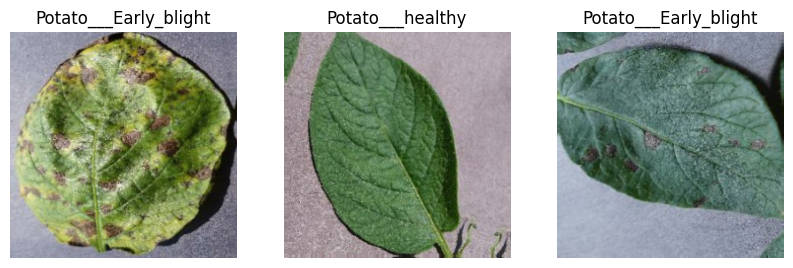

In [57]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in augmented_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Applying Data Augmentation to Train Dataset


In [58]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

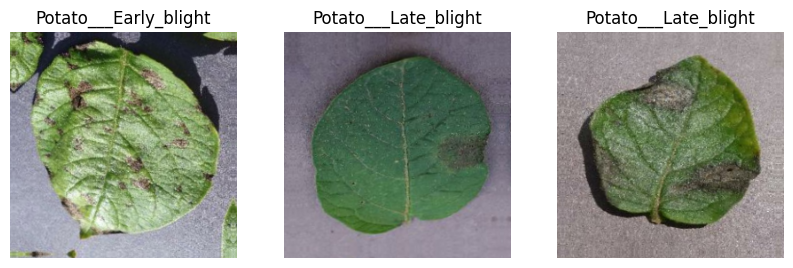

In [59]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Model Architecture


In [60]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),              # <--- Flatten feature maps
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  #
])

model.build(input_shape=input_shape)
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (3, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (3, 254, 254, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (3, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (3, 516128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (3, 128)               │    66,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (3, 3)                 │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,065,795 (252.02 MB)

 Trainable params: 66,065,795 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model


In [61]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [62]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.2500 - loss: 51.7108 - val_accuracy: 0.3333 - val_loss: 14.7852
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.2083 - loss: 12.2767 - val_accuracy: 0.3333 - val_loss: 6.7423
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.4167 - loss: 2.4181 - val_accuracy: 0.3333 - val_loss: 1.5745
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.5000 - loss: 1.8245 - val_accuracy: 0.3333 - val_loss: 2.4377
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.3750 - loss: 2.1130 - val_accuracy: 1.0000 - val_loss: 0.7303
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.5000 - loss: 1.7424 - val_accuracy: 0.3333 - val_loss: 1.1935
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.2917 - loss: 2.1292 - val_accuracy: 0.6667 - val_loss: 1.4409
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.5000 - loss: 1.1923 - val_accuracy: 0.6667 - val_lo

In [63]:
scores = model.evaluate(test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6667 - loss: 0.8332


In [64]:
scores

[0.833185613155365, 0.6666666865348816]

actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
predicted label: Potato___Early_blight


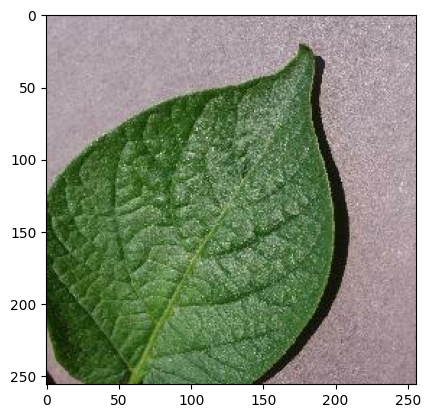

In [65]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


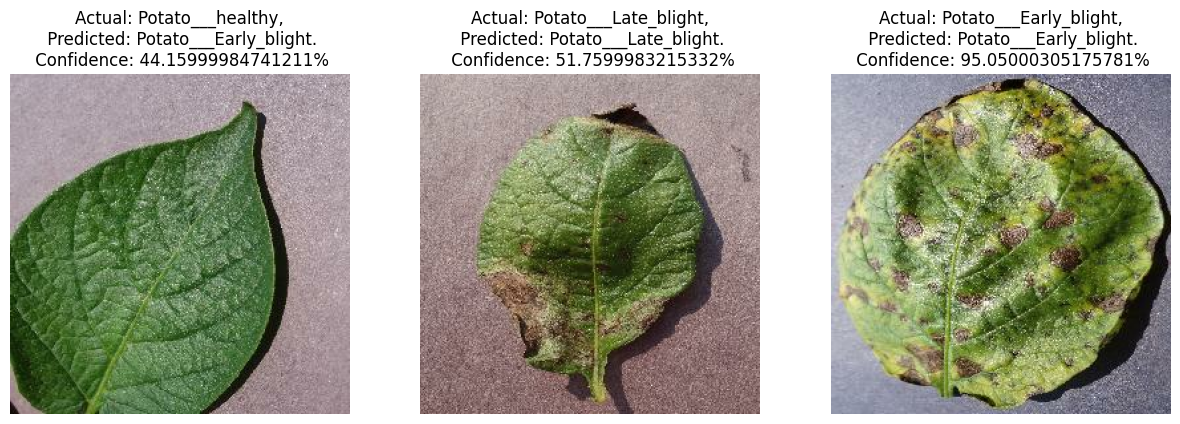

In [71]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")